In [1]:
import pandahouse
import hashlib
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше по сравнению с обычным CTR?

In [18]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20240620.feed_actions  
WHERE toDate(time) between '2024-05-31' and '2024-06-06'
    and exp_group in (0,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

exp_group = 0 – Все по-старому
exp_group = 3 - Рекомендации "постов, которые лайкали похожие на вас люди"

Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠)

In [7]:
CTR_control = sum(df.loc[df.exp_group == 0].likes) / sum(df.loc[df.exp_group == 0].views)

Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 

In [9]:
linearized_likes_0 = df.loc[df.exp_group == 0].likes - CTR_control * df.loc[df.exp_group == 0].views 

In [10]:
linearized_likes_3 = df.loc[df.exp_group == 3].likes - CTR_control * df.loc[df.exp_group == 3].views 

После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠

In [11]:
stats.ttest_ind(linearized_likes_0,
                linearized_likes_3,
                equal_var=False)

Ttest_indResult(statistic=-16.186230032932844, pvalue=1.4918137745326139e-58)

In [19]:
stats.ttest_ind(df[df.exp_group == 0].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-13.935320516755773, pvalue=6.216047483062228e-44)

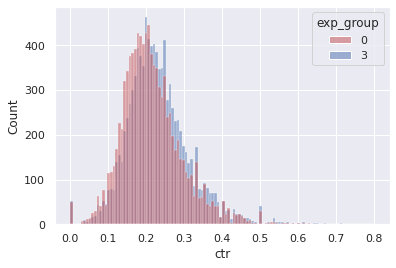

In [20]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = df,
                      x='ctr',
                      hue='exp_group',
                      palette = ['r', 'b'],
                      alpha=0.5,
                      kde=False)

Как можно заметить значения т теста в обоих случаях, статистически значемый поэтому мы можем что разность в экспериментальных гурппах есть. По графику распределения видно что у двух групп нормальное распределение. Именно поэтому нет значимых различий в p значениях

In [21]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20240620.feed_actions  
WHERE toDate(time) between '2024-05-31' and '2024-06-06'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

exp_group = 1 - Все по-старому
exp_group = 2 - Рекомендации "похожих на лайкнутые постов"

In [13]:
CTR_control = sum(df.loc[df.exp_group == 1].likes) / sum(df.loc[df.exp_group == 1].views)

In [14]:
linearized_likes_1 = df.loc[df.exp_group == 1].likes - CTR_control * df.loc[df.exp_group == 1].views 

In [15]:
linearized_likes_2 = df.loc[df.exp_group == 2].likes - CTR_control * df.loc[df.exp_group == 2].views 

In [16]:
stats.ttest_ind(linearized_likes_1,
                linearized_likes_2,
                equal_var=False)

Ttest_indResult(statistic=5.936377101934478, pvalue=2.9805064038668388e-09)

In [22]:
# t-тест
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

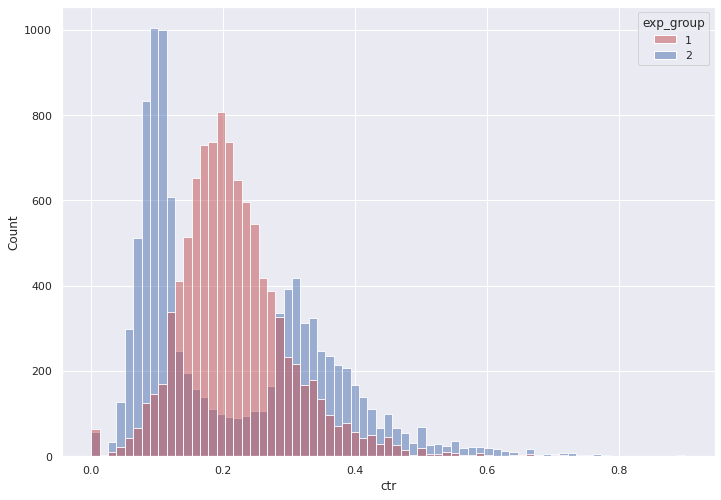

In [23]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = df,
                      x='ctr',
                      hue='exp_group',
                      palette = ['r', 'b'],
                      alpha=0.5,
                      kde=False)

p значения при обычном ctr не показал значимых разлиций, но новый метод показал достаточно маленькое p значения. Все из-за ненармольнасти данных в второй экспериментальной группы. Следовательно можно предположить что данный метод эффективен когда наши данные ненармальны. 